# Identifying the target genes for the transcription factor MYB in leukemia cells (K-562)

The data for this analysis comes from the paper "Chromatin occupancy and target genes of the haematopoietic master transcription factor MYB" published by Lemma et al in 2021. With their ChIP-Seq data from K-562 cells, I will perform a bioinformatic analysis of MYB to identify the target genes for this transcription favors and enriched regions in the genome. 

In [6]:
cd /home/luna.kuleuven.be/r0913112/data/jupyternotebooks/Regulatory-Genomics/Task-2-1

In [2]:
#We will create a directory in which all the fastq files will go. It will be called "fastq-files"
mkdir fastq-files

In [3]:
fastq-dump \
    SRR8382997 SRR8383003 \
    --split-files \
    --outdir fastq-files \
    --verbose

Preference setting is: Prefer SRA Lite files with simplified base quality scores if available.
SRR8382997 is an SRA Lite file with simplified base quality scores.
Rejected 48707643 READS because READLEN < 1
Read 48707643 spots for SRR8382997
Written 48707643 spots for SRR8382997
SRR8383003 is an SRA Lite file with simplified base quality scores.
Rejected 51612167 READS because READLEN < 1
Read 51612167 spots for SRR8383003
Written 51612167 spots for SRR8383003


### FASTQC
Firstly, I will change the names of my files. This will allow me to have a more organized workspace and recognize which file I am working with at each step of the way. I will then run FASTQC to check the quality of the reads. The results of this test show that all reads have high quality scored (Phred > 30), with no sequences flagged as poor quality.

In [4]:
cd fastq-files
mv SRR8382997_1.fastq MYB.fastq
mv SRR8383003_1.fastq input.fastq

fastqc MYB.fastq
fastqc input.fastq

Started analysis of MYB.fastq
Approx 5% complete for MYB.fastq
Approx 10% complete for MYB.fastq
Approx 15% complete for MYB.fastq
Approx 20% complete for MYB.fastq
Approx 25% complete for MYB.fastq
Approx 30% complete for MYB.fastq
Approx 35% complete for MYB.fastq
Approx 40% complete for MYB.fastq
Approx 45% complete for MYB.fastq
Approx 50% complete for MYB.fastq
Approx 55% complete for MYB.fastq
Approx 60% complete for MYB.fastq
Approx 65% complete for MYB.fastq
Approx 70% complete for MYB.fastq
Approx 75% complete for MYB.fastq
Approx 80% complete for MYB.fastq
Approx 85% complete for MYB.fastq
Approx 90% complete for MYB.fastq
Approx 95% complete for MYB.fastq
Analysis complete for MYB.fastq
Started analysis of input.fastq
Approx 5% complete for input.fastq
Approx 10% complete for input.fastq
Approx 15% complete for input.fastq
Approx 20% complete for input.fastq
Approx 25% complete for input.fastq
Approx 30% complete for input.fastq
Approx 35% complete for input.fastq
Approx 40%

### BOWTIE2
After confirming the quality of the reads, I will map them to a reference human genome. This is done with the hg19 human assembly (GRCh37). This mapping will produce 2 SAM files (one for each of the test data and one for the input data).

In [8]:
cd /home/luna.kuleuven.be/r0913112/data/jupyternotebooks/Regulatory-Genomics/Task-2-1

bowtie2 -x /mnt/storage/data/resources/bowtie2/hg19 fastq-files/MYB.fastq -S MYB.sam
bowtie2 -x /mnt/storage/data/resources/bowtie2/hg19 fastq-files/input.fastq -S input.sam

48707643 reads; of these:
  48707643 (100.00%) were unpaired; of these:
    6367494 (13.07%) aligned 0 times
    29755717 (61.09%) aligned exactly 1 time
    12584432 (25.84%) aligned >1 times
86.93% overall alignment rate
51612167 reads; of these:
  51612167 (100.00%) were unpaired; of these:
    3118368 (6.04%) aligned 0 times
    36637735 (70.99%) aligned exactly 1 time
    11856064 (22.97%) aligned >1 times
93.96% overall alignment rate


### SAMTOOLS
SAM files are useful, but they are very heavy and it's more useful to work with BAM files. For this reason, we will use SAMTOOLS to convert our .sam into .bam files. After the creation of the BAM files, both the FASTQ and the SAM files are deleted to save some space (each file is >10Gb). Additionally, we will use this program to know how many reads of the files mapped to the reference genome. Out of the 48707643 reads of the test data, 42340149 mapped to the reference genome. For the input, 48493799 out of 51612167 reads mapped. 

In [9]:
# Generate BAM files. 
samtools view -S -b MYB.sam > MYB.bam
samtools view -S -b input.sam > input.bam

# All reads for each file.
samtools view -c MYB.bam
samtools view -c input.bam

# List all SAM flags.
samtools flags

# Get correct flag settings for samtools view (second column).
samtools flags UNMAP,SECONDARY

# Number of mapped reads.
samtools view -c -F 260 MYB.bam
samtools view -c -F 260 input.bam

48707643
51612167

About: Convert between textual and numeric flag representation
Usage: samtools flags INT|STR[,...]

Flags:
	0x1	PAIRED        .. paired-end (or multiple-segment) sequencing technology
	0x2	PROPER_PAIR   .. each segment properly aligned according to the aligner
	0x4	UNMAP         .. segment unmapped
	0x8	MUNMAP        .. next segment in the template unmapped
	0x10	REVERSE       .. SEQ is reverse complemented
	0x20	MREVERSE      .. SEQ of the next segment in the template is reversed
	0x40	READ1         .. the first segment in the template
	0x80	READ2         .. the last segment in the template
	0x100	SECONDARY     .. secondary alignment
	0x200	QCFAIL        .. not passing quality controls
	0x400	DUP           .. PCR or optical duplicate
	0x800	SUPPLEMENTARY .. supplementary alignment

0x104	260	UNMAP,SECONDARY
42340149
48493799


Now, it's useful to visualize these mapped reads using the IGV software. However, to do this, I first need to create an index bam file (.bai) to load into IGV alongside the .bam file. 

In [10]:
samtools sort -O bam -o MYB.sorted.bam MYB.bam
samtools sort -O bam -o input.sorted.bam input.bam

samtools index MYB.sorted.bam
samtools index input.sorted.bam

[bam_sort_core] merging from 14 files and 1 in-memory blocks...
[bam_sort_core] merging from 15 files and 1 in-memory blocks...


### IGV
The IGV software is useful for interactively visualizing large, integrated data sets. In order to visualize my mapped reads, I will download all the .sorted.bam and .bai files to my computer and visualize them here. The overall visualization is of the whole genome. A way to locate enrichment of reads is to visualize specific genes, for example target genes of our transcription factor MYB.

I will download the `MYB.sorted.bam` and the `MYB.sorted.bam.bai` files to visualize in the IGV software. Moreover, I will look for a known target of MYB to look for peaks (enrichment of reads). Previously reported target genes for MYB are MYADM, LMO2, GATA2, STAT5A, and IKZF1 (Lorenzo et al 2011). I will go to GATA2, one of the target genes of MYB, located on chromosome 3. I see an enrichment of reads, or a "peak" in the first intron of GATA2, and further peaks in the following introns. 

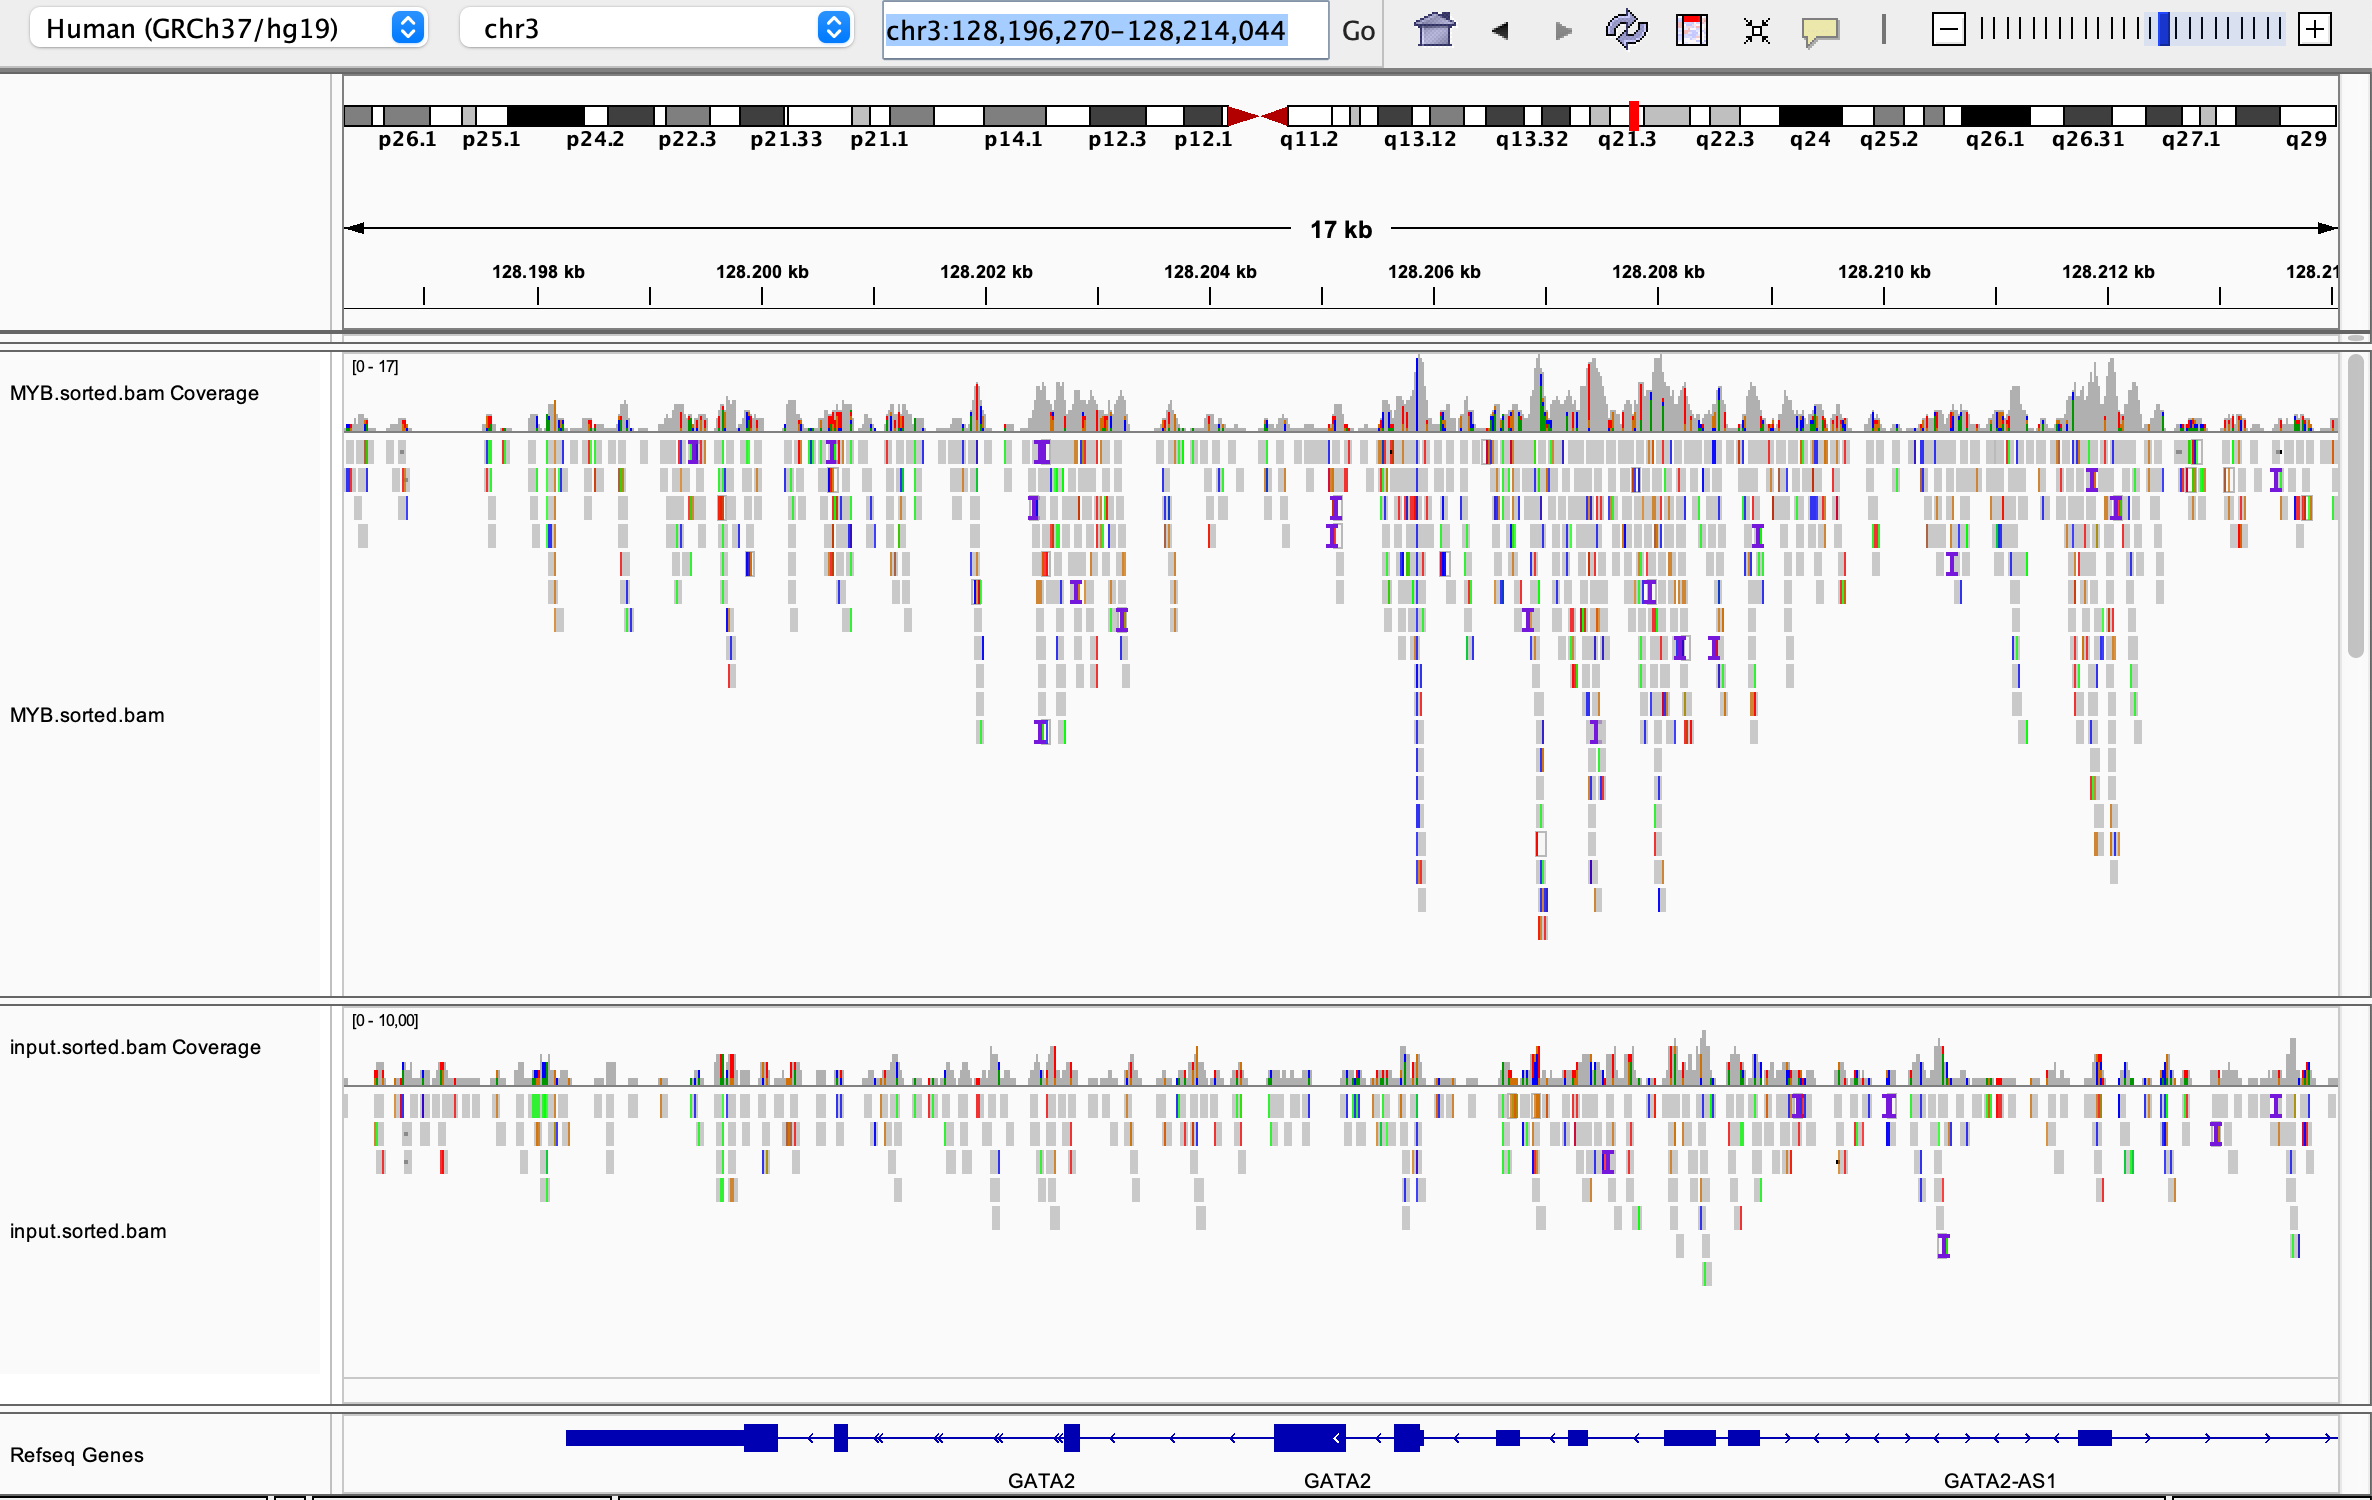

## Genome-wide coverage plots
I will generate a bigWig (.bw) file that contains only the coverage of the reads. According to deeptools, the effective genome size of the GRCh37 human genome is 2864785220 (https://deeptools.readthedocs.io/en/develop/content/feature/effectiveGenomeSize.html). This .bw file will be visualized on IGV as well. From the ChIP-Atlas page of this data set http://chip-atlas.org/view?id=SRX5192942, I will visualize the bigWig file for the hg19 reference and open it on the IGV software as well.

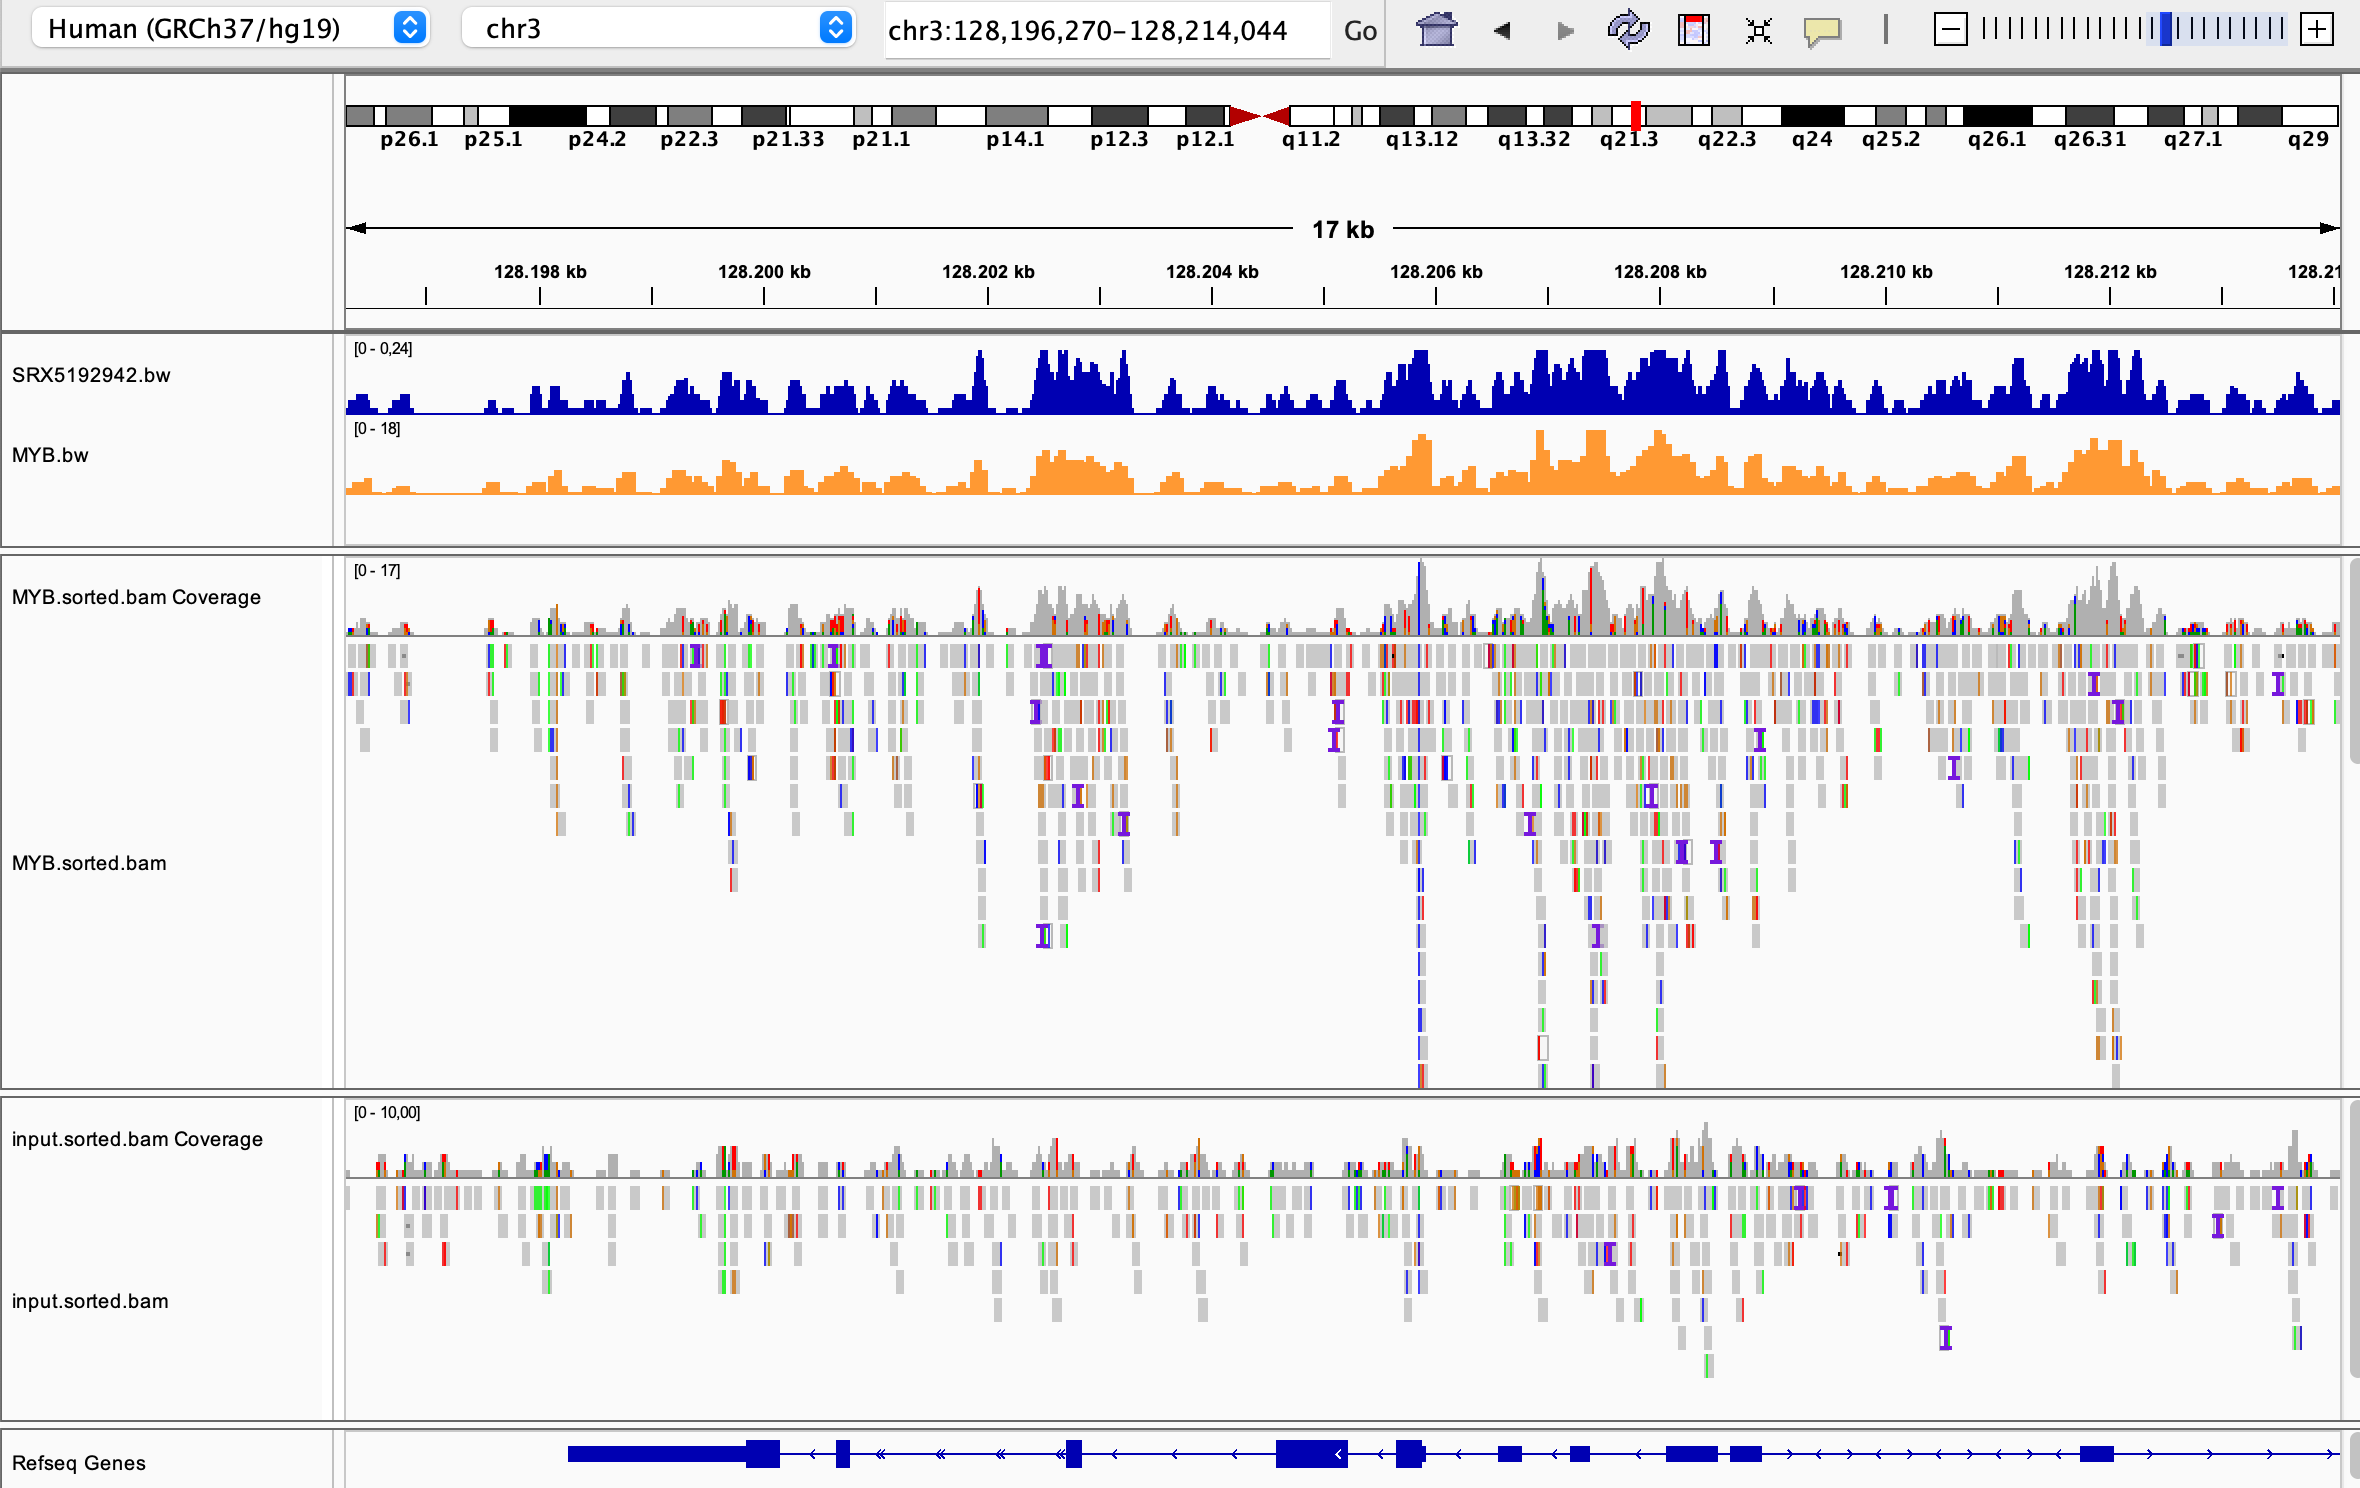

In [11]:
bamCoverage -b MYB.sorted.bam --normalizeUsing RPGC --effectiveGenomeSize 2864785220 -o MYB.bw
bamCoverage -b input.sorted.bam --normalizeUsing RPGC --effectiveGenomeSize 2864785220 -o input.bw

normalization: 1x (effective genome size 2864785220)
bamFilesList: ['MYB.sorted.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: read length
numberOfProcessors: 1
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000
normalization: 1x (effective genome size 2864785220)
bamFilesList: ['input.sorted.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: read length
numberOfProcessors: 1
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exc

## Peak calling with MACS2
MACS2 is a  tool for identifying transcription factor binding sites. It implements a model to take advantage of the strand shift, to distinguish real peaks from artifacts.

In [1]:
macs2 callpeak -t MYB.bam -c input.bam -n MYB -g hs -q 0.05 --nomodel --extsize 122 #hs is an abbreviation for human genome size

cat MYB_peaks.narrowPeak | wc -l

cat MYB_peaks.narrowPeak | cut -f 1-3 > MYB_peaks.bed

computeMatrix reference-point \
    -S MYB.bw \
    -R MYB_peaks.bed \
    --referencePoint center \
    -a 2000 \
    -b 2000 \
    --binSize 5 \
    -out MYB.tab.gz

plotHeatmap \
    -m MYB.tab.gz \
    -out MYB-peaks5.png \
    --heatmapHeight 15  \
    --refPointLabel peak.center \
    --regionsLabel peaks \
    --plotTitle 'ChIP-seq signal MYB TF'

INFO  @ Fri, 29 Dec 2023 23:46:24: 
# Command line: callpeak -t MYB.bam -c input.bam -n MYB -g hs -q 0.05 --nomodel --extsize 122
# ARGUMENTS LIST:
# name = MYB
# format = AUTO
# ChIP-seq file = ['MYB.bam']
# control file = ['input.bam']
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calling is off
# Paired-End mode is off
 
INFO  @ Fri, 29 Dec 2023 23:46:24: #1 read tag files... 
INFO  @ Fri, 29 Dec 2023 23:46:24: #1 read treatment tags... 
INFO  @ Fri, 29 Dec 2023 23:46:24: Detected format is: BAM 
INFO  @ Fri, 29 Dec 2023 23:46:24: * Input file is gzipped. 
INFO  @ Fri, 29 Dec 2023 23:46:29:  1000000 
INFO  @ Fri, 29 Dec 2023 23

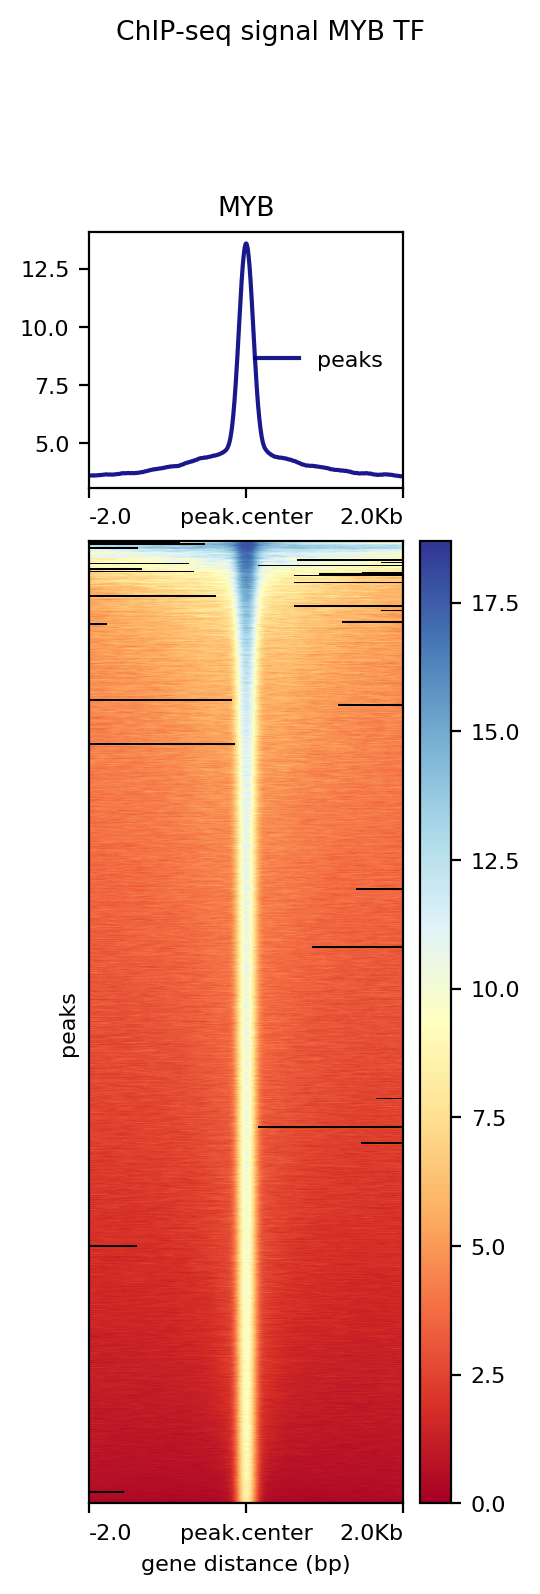

## Motif analysis
### 1. De novo motif discovery
To discover motifs de novo, I will run RSAT on their website with my peak files (FASTA). To obtain this FASTA file, I will upload my bed file to this website (http://rsat.sb-roscoff.fr/fetch-sequences_form.php) which will fetch the sequences for me. These fasta.txt files are uploaded to the peak-motifs tool of RSAT and a job begins to run. This takes a while, but after a couple of hours, I finally have some results. This is the link to the results: http://rsat.sb-roscoff.fr/tmp/apache/2024/01/01/peak-motifs.2024-01-01.132859_2024-01-01.132859_p7SRWX/peak-motifs_synthesis.html

This is the first part of the RSAT peak-motifs output: sequence composition

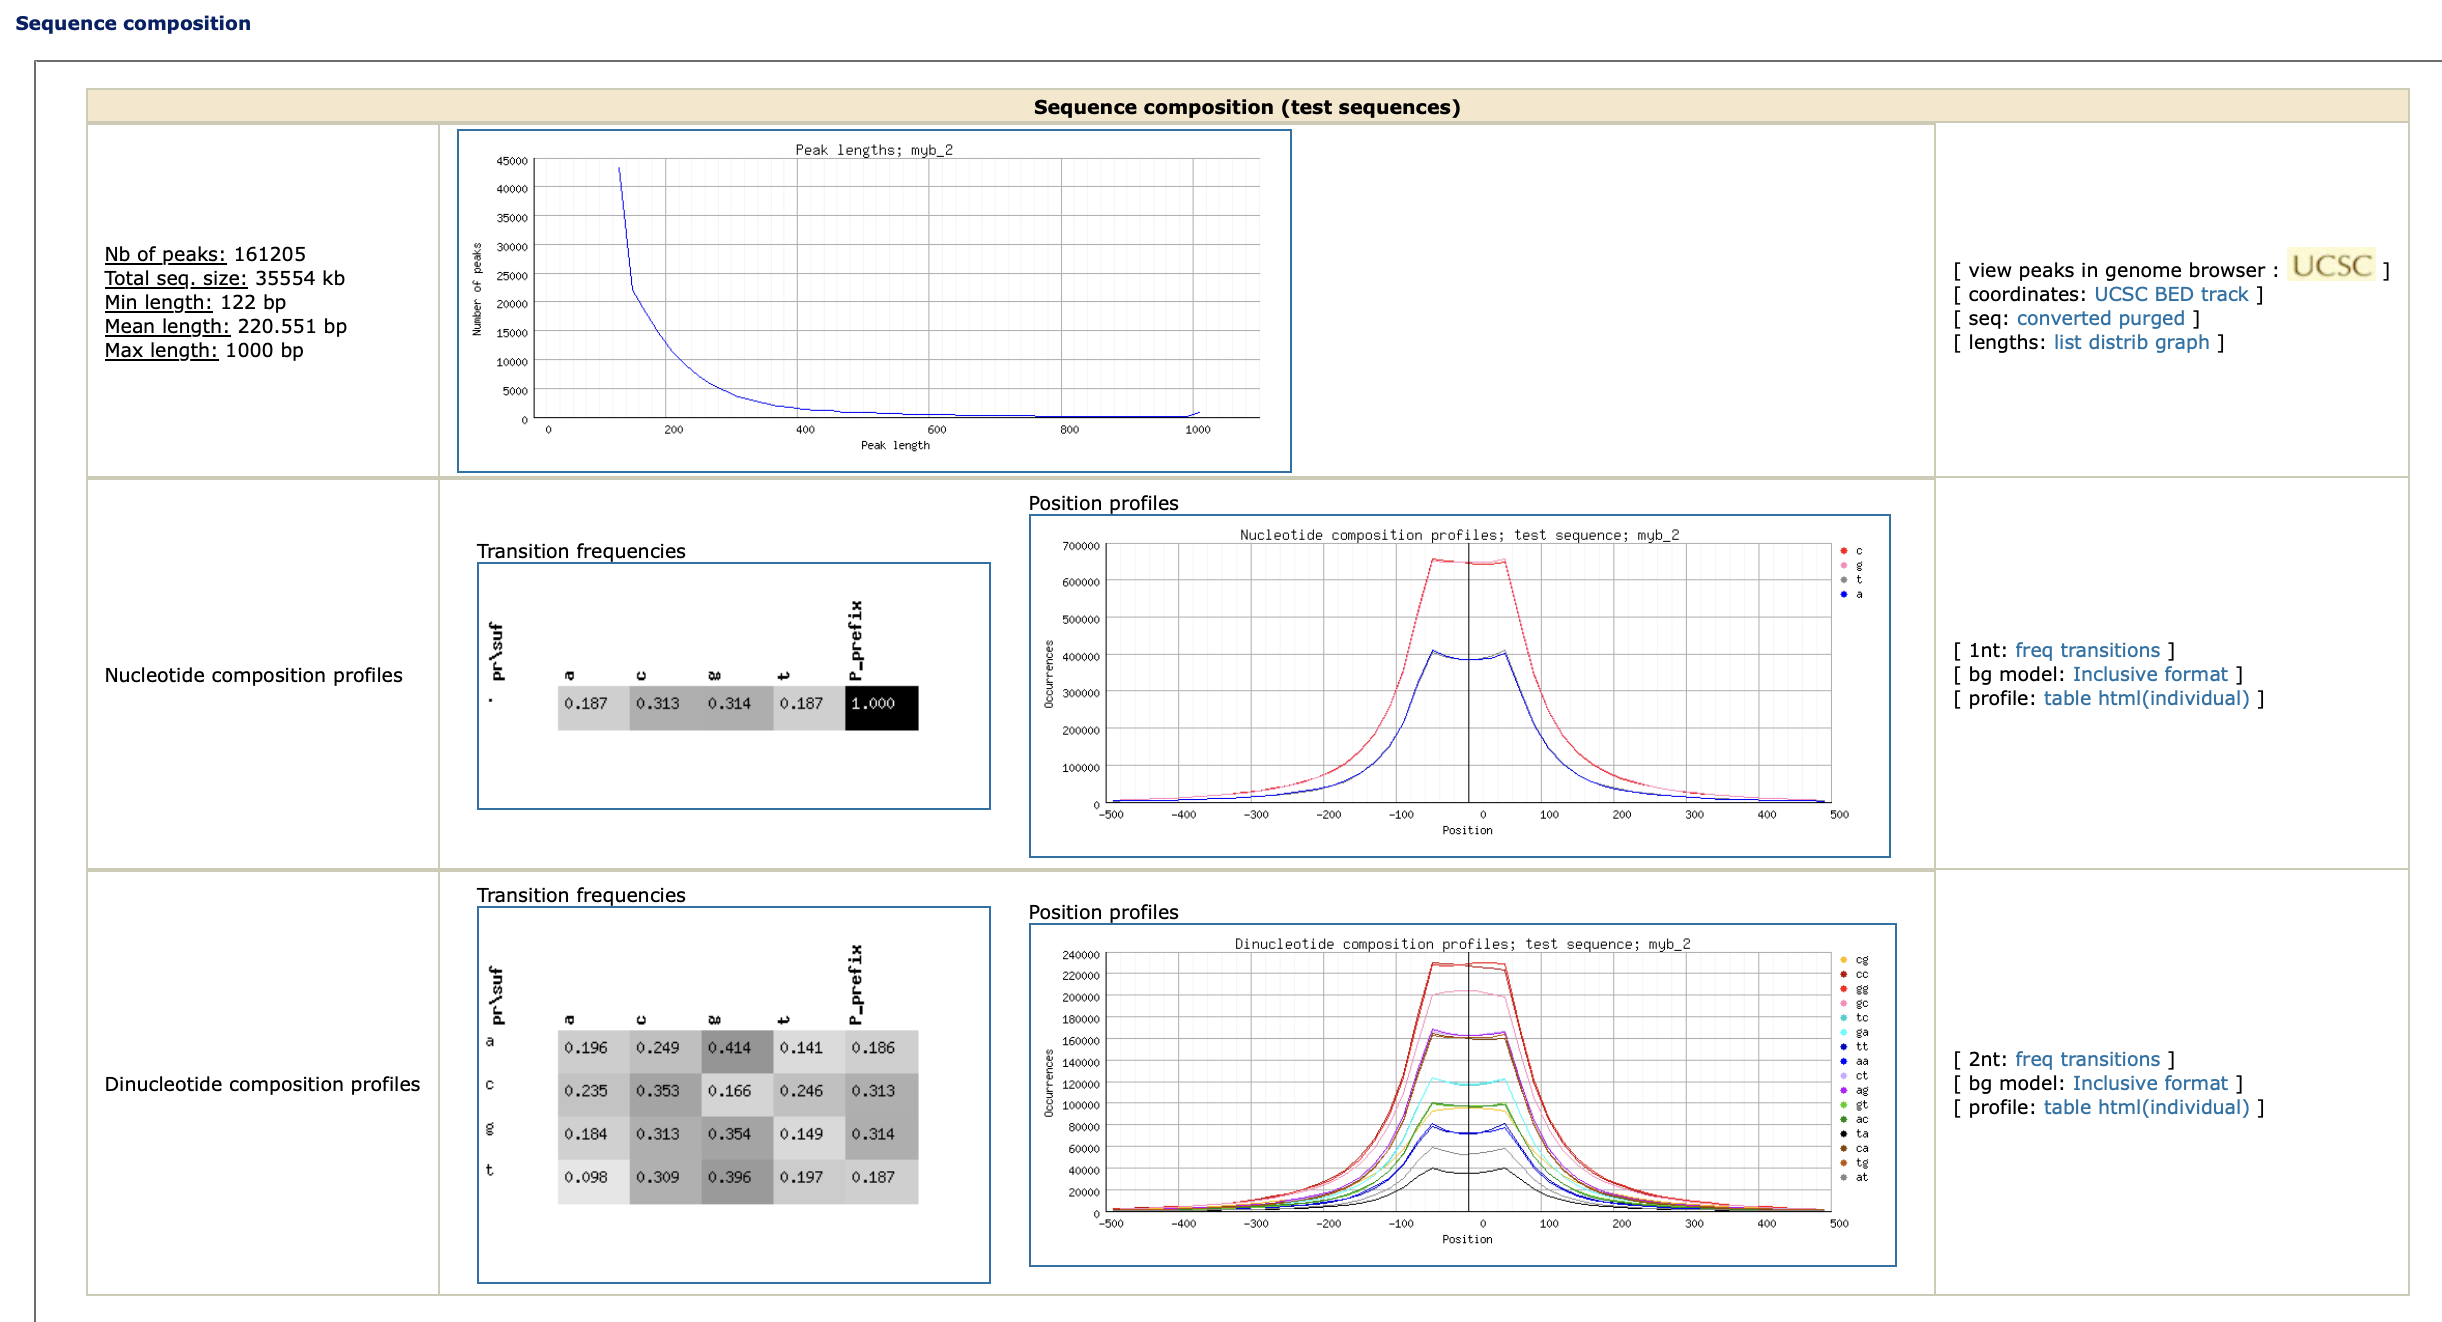

Next is the first motif, which is assigned to three possible motifs: SP9, KLF15, and SP3. It has an incredibly high k-mer significance, an e-value of zero, and most of the matches occur in the center of the peak. 

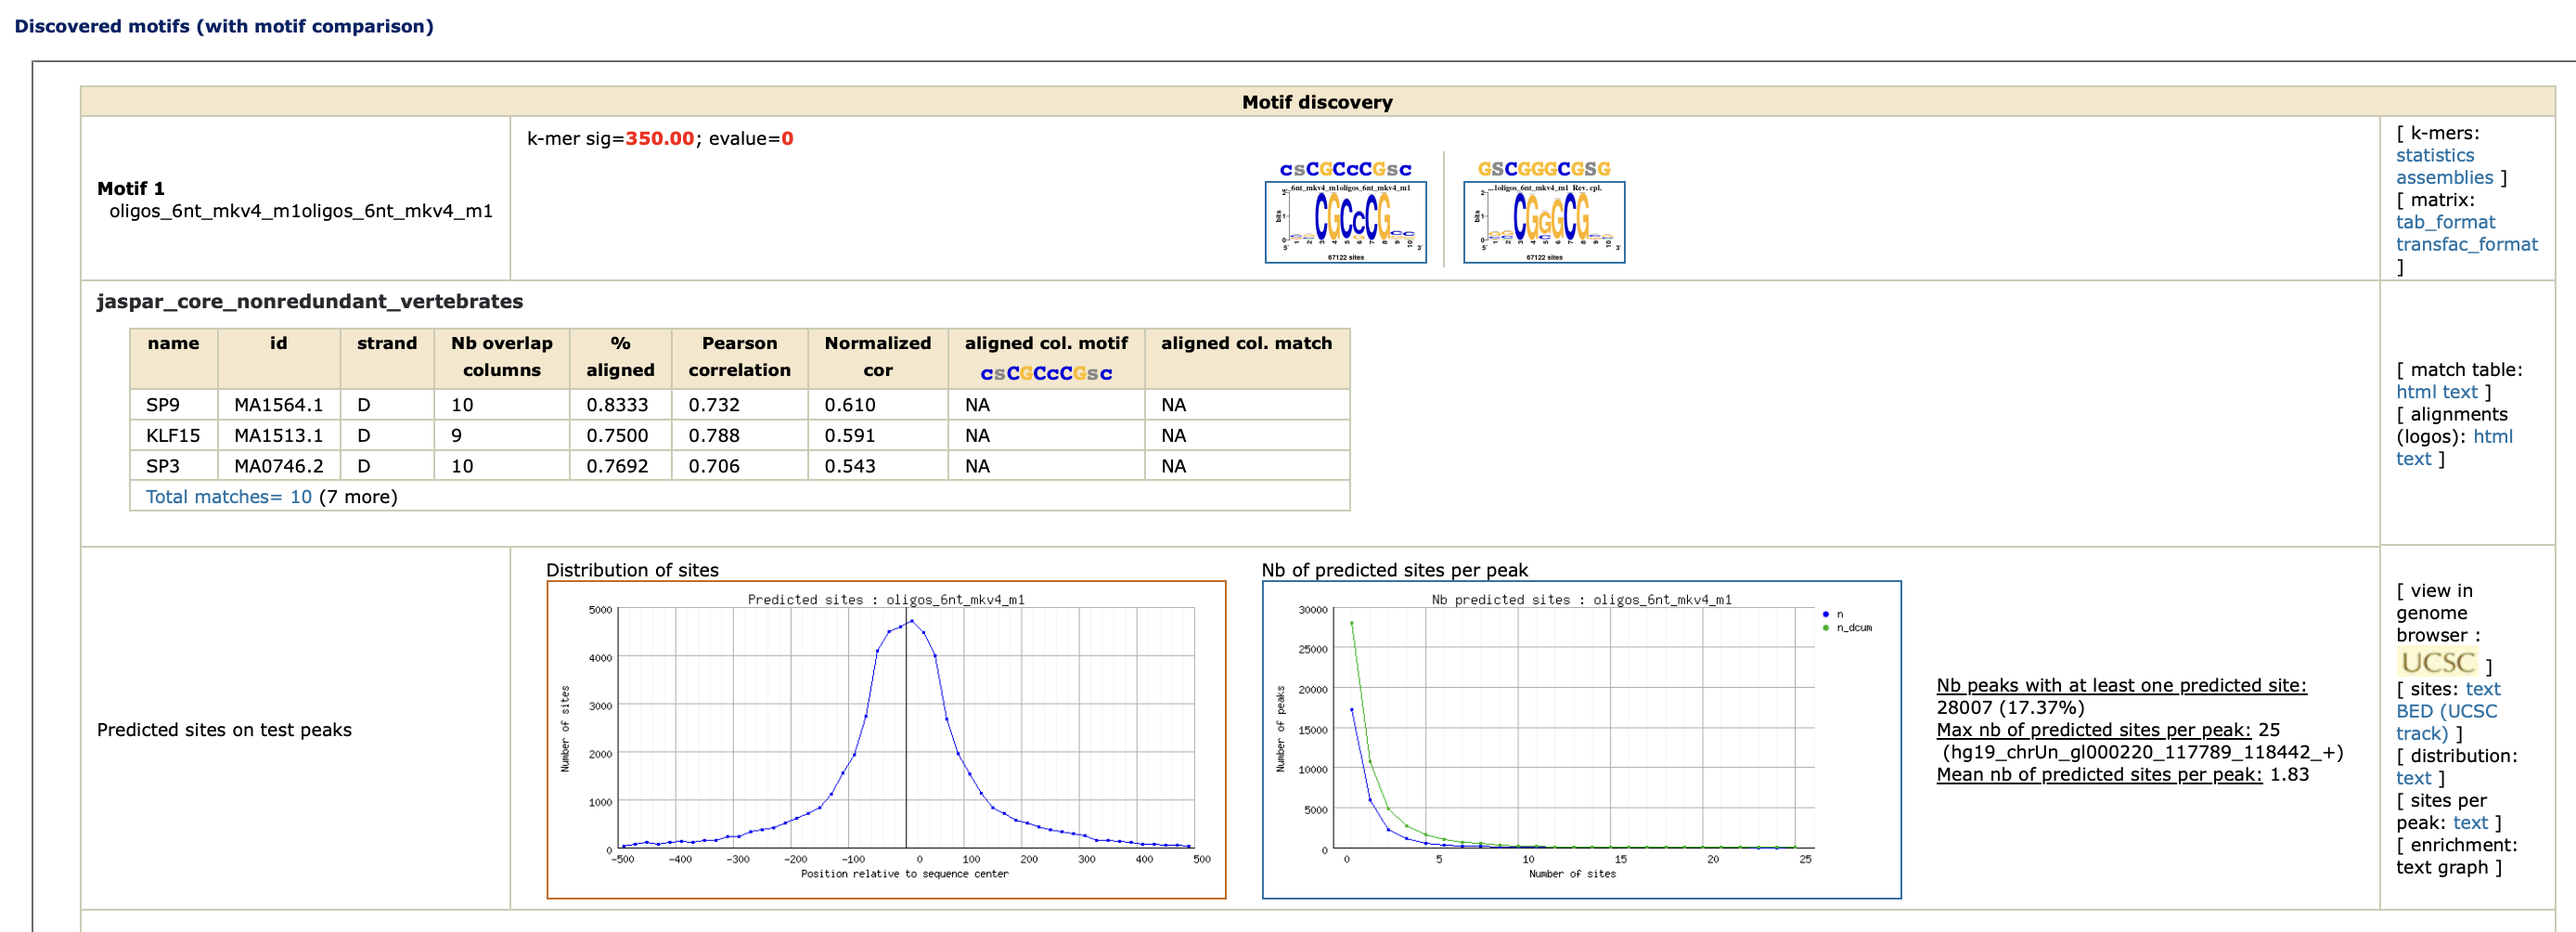

### 2. Create a BED file with only the DIRECT peaks

In [18]:
cd /home/luna.kuleuven.be/r0913112/data/jupyternotebooks/Regulatory-Genomics/Task-2-1

cat peak-motifs_oligos_6nt_mkv4_m1_sites.tab | grep -v ";" | grep -v '#' | head

hg19_chr1_10453_10582_+	site	oligos_6nt_mkv4_m1oligos_6nt_mkv4_m1	D	-31	-22	CCCGCCCGCC	8.8
hg19_chr1_10453_10582_+	site	oligos_6nt_mkv4_m1oligos_6nt_mkv4_m1	D	-27	-18	CCCGCCCGGG	7.8
hg19_chr1_28913_29442_+	site	oligos_6nt_mkv4_m1oligos_6nt_mkv4_m1	D	50	59	CCCGCCCGCC	8.8
hg19_chr1_28913_29442_+	site	oligos_6nt_mkv4_m1oligos_6nt_mkv4_m1	D	223	232	TCCGCCCGCG	8.6
hg19_chr1_51549_51724_+	site	oligos_6nt_mkv4_m1oligos_6nt_mkv4_m1	R	-51	-42	CGCGCCCGGC	9.6
hg19_chr1_51549_51724_+	site	oligos_6nt_mkv4_m1oligos_6nt_mkv4_m1	R	-2	7	TCCGCCCGCC	8.4
hg19_chr1_457294_457453_+	site	oligos_6nt_mkv4_m1oligos_6nt_mkv4_m1	D	-22	-13	TCCGCCCGCC	8.4
hg19_chr1_457294_457453_+	site	oligos_6nt_mkv4_m1oligos_6nt_mkv4_m1	D	27	36	CGCGCCCGGC	9.6
hg19_chr1_713914_714608_+	site	oligos_6nt_mkv4_m1oligos_6nt_mkv4_m1	R	-65	-56	CCCGCCCGGC	8.5
hg19_chr1_713914_714608_+	site	oligos_6nt_mkv4_m1oligos_6nt_mkv4_m1	R	50	59	TGCGCCCGGC	8.2
grep: write error: Broken pipe
grep: write error: Broken pipe
cat: write error: Broken pipe

In [19]:
cat peak-motifs_oligos_6nt_mkv4_m1_sites.tab | grep -v ";" | grep -v '#' | cut -f 1 | tr "_" "\t" | cut -f 2-4 | head

chr1	10453	10582
chr1	10453	10582
chr1	28913	29442
chr1	28913	29442
chr1	51549	51724
chr1	51549	51724
chr1	457294	457453
chr1	457294	457453
chr1	713914	714608
chr1	713914	714608
cut: write error: Broken pipe


In [20]:
cat peak-motifs_oligos_6nt_mkv4_m1_sites.tab | grep -v ";" | grep -v '#' | cut -f 1 | tr "_" "\t" | cut -f 2-4 > allpeaks-with-motif-RSAT.bed

### 3. PWM and track enrichment
After the de novo motif enrichment, I will check if the ChIP-seq peaks are enriched for matches to known PSSMs (PWMs) from PSSM databases like JASPAR, TRANFAC, cis-bp, HOCOMOCO, etc.

In addition, I will check whether my peaks overlap significantly with other epigenomic data sets, called "tracks". 

i-cisTarget will test for enrichment of motifs, using a collection of databases of PSSMs, as well as tracks. I uploaded the ChIP-Seq peak bed file to i-cisTarget and had to wait also a couple of hours to get the results for my dataset. This is the link for the results: https://gbiomed.kuleuven.be/apps/lcb/i-cisTarget/reports/cce171b6e9a7846491ac1aea5c0beba85371da26/report.html

I can first see the parameters and statistics for this analysis. 
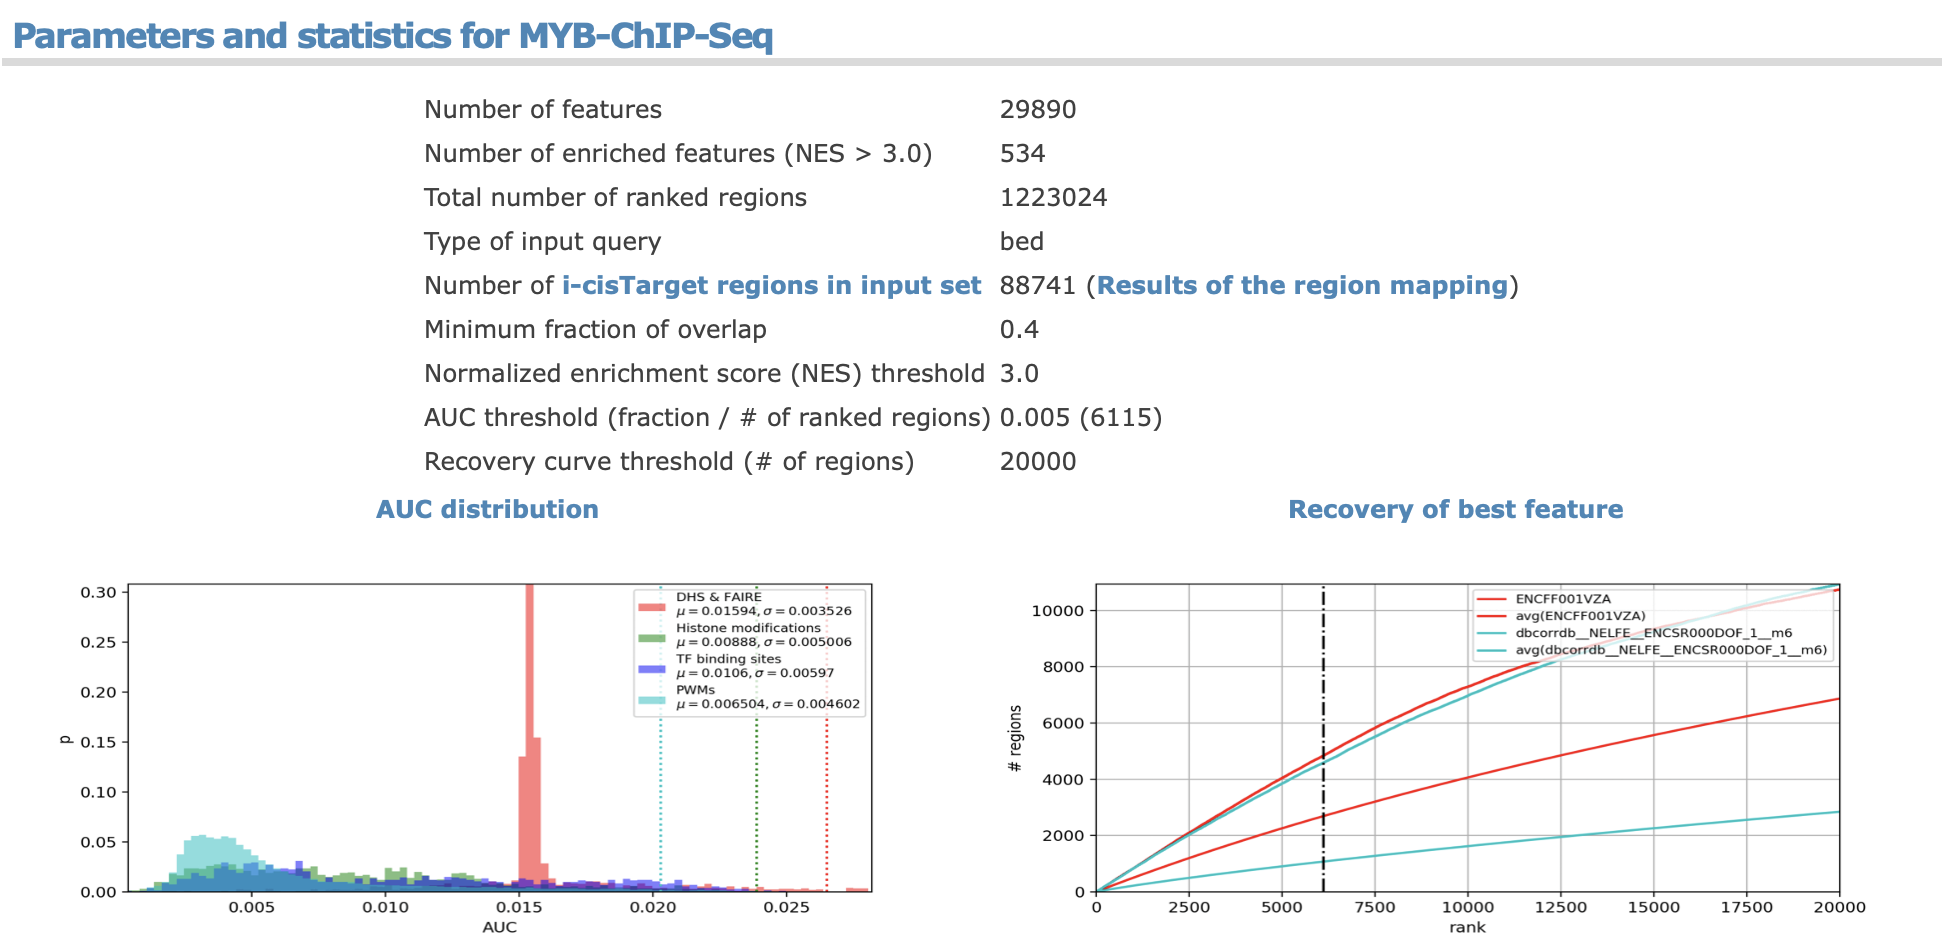

More interesting, however, are the results for my query. The top 5 features are shown below.
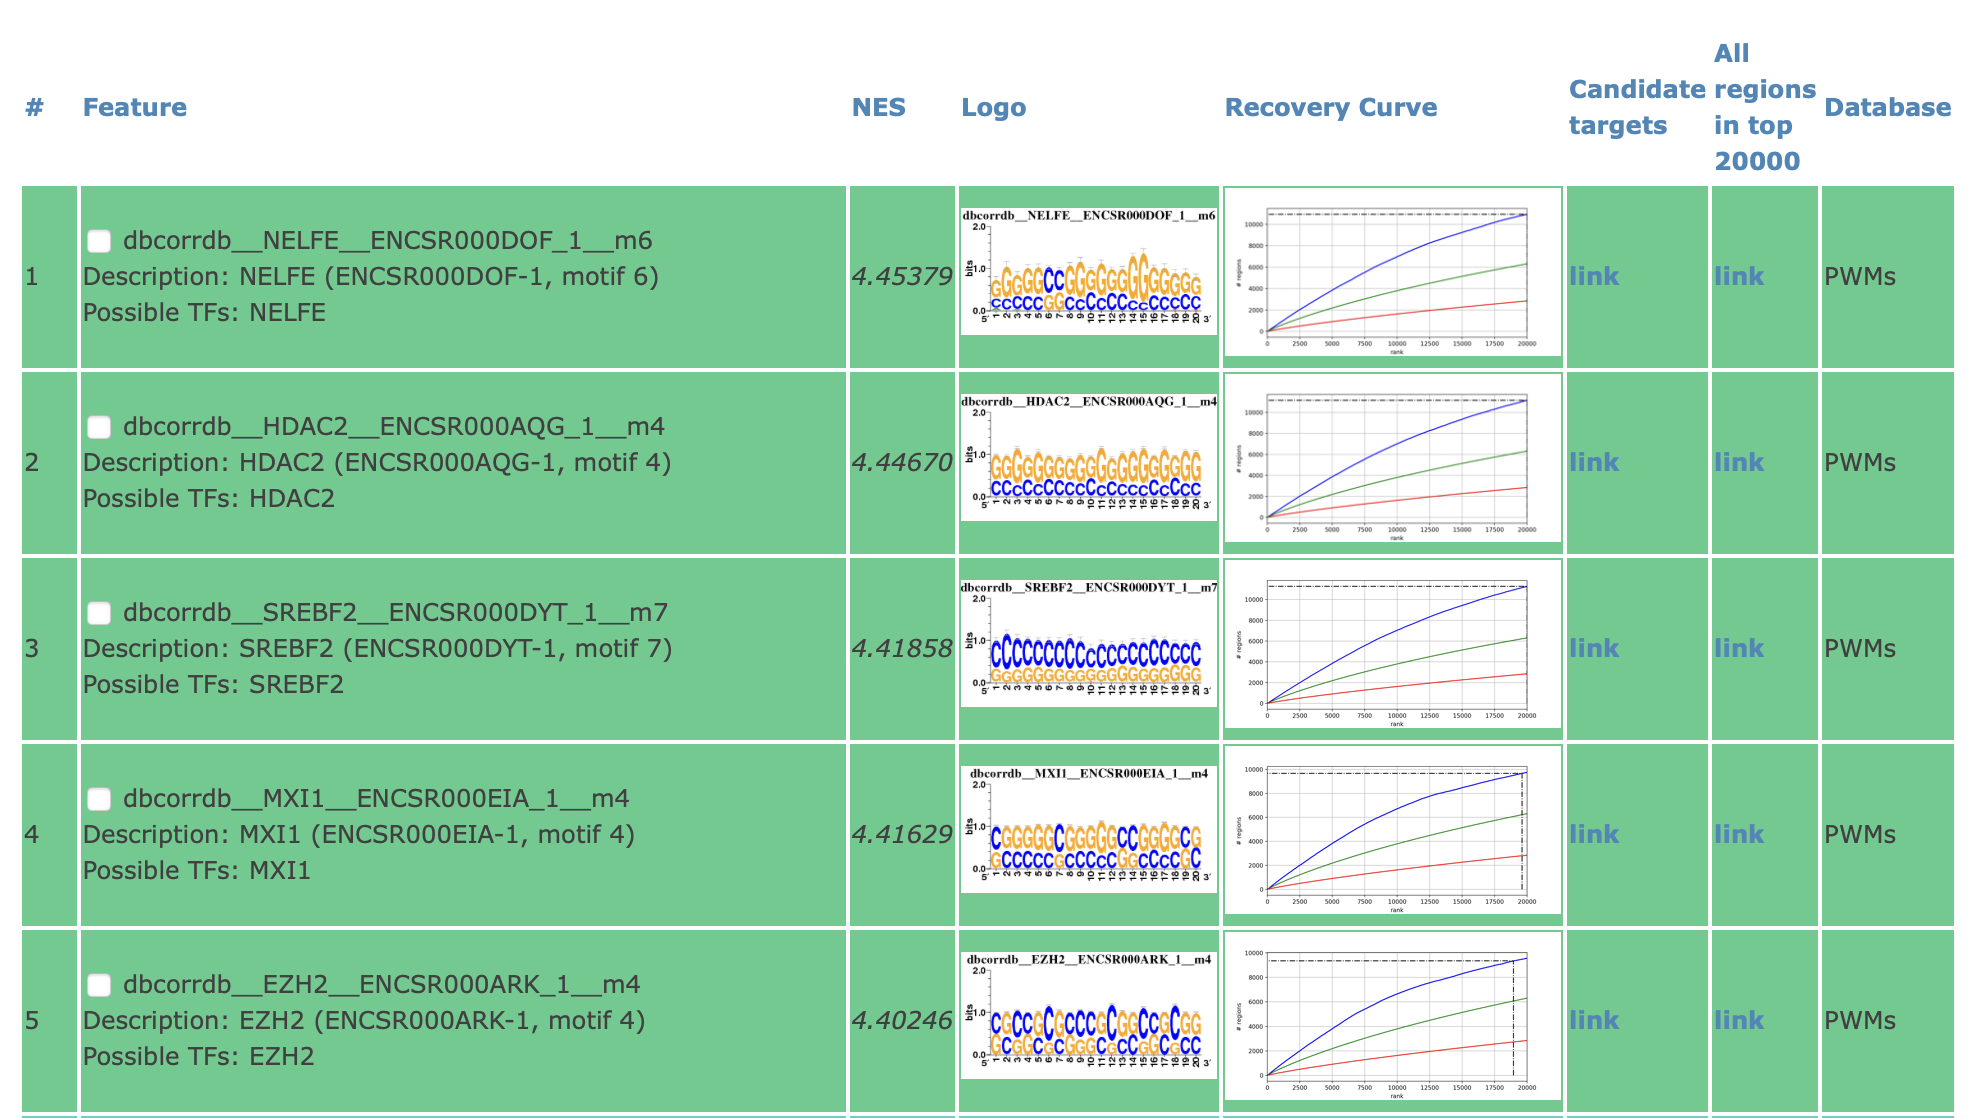

The BED file from the first link of the candidate genes contains the regions in the leading edge, having a strong motif match. 

In [15]:
cd /home/luna.kuleuven.be/r0913112/data/jupyternotebooks/Regulatory-Genomics/Task-2-1

cat dbcorrdb__NELFE__ENCSR000DOF_1__m6.targets.bed | head

track name=dbcorrdb__NELFE__ENCSR000DOF_1__m6_candidate_targets description="" useScore=1
chr1	21994345	21997335	chr1-reg23298
chr2	97192824	97194855	chr2-reg67517
chr4	76911994	76912804	chr4-reg43937
chr12	43945724	43947315	chr12-reg28731
chr21	47705901	47706827	chr21-reg24600
chr10	88515314	88517610	chr10-reg59520
chr1	235490234	235493195	chr1-reg173886
chr15	44829625	44830525	chr15-reg16353
chr12	133338384	133339305	chr12-reg96865
cat: write error: Broken pipe


In [16]:
cat dbcorrdb__NELFE__ENCSR000DOF_1__m6.targets.bed | wc -l

10932


## Link peaks to genes
I am going to use GREAT to link the peaks in my dataset to genes. GREAT also determines Gene Ontology (GO) enrichment of the linked (target) genes. I will use all my MYB peaks (direct and indirect).

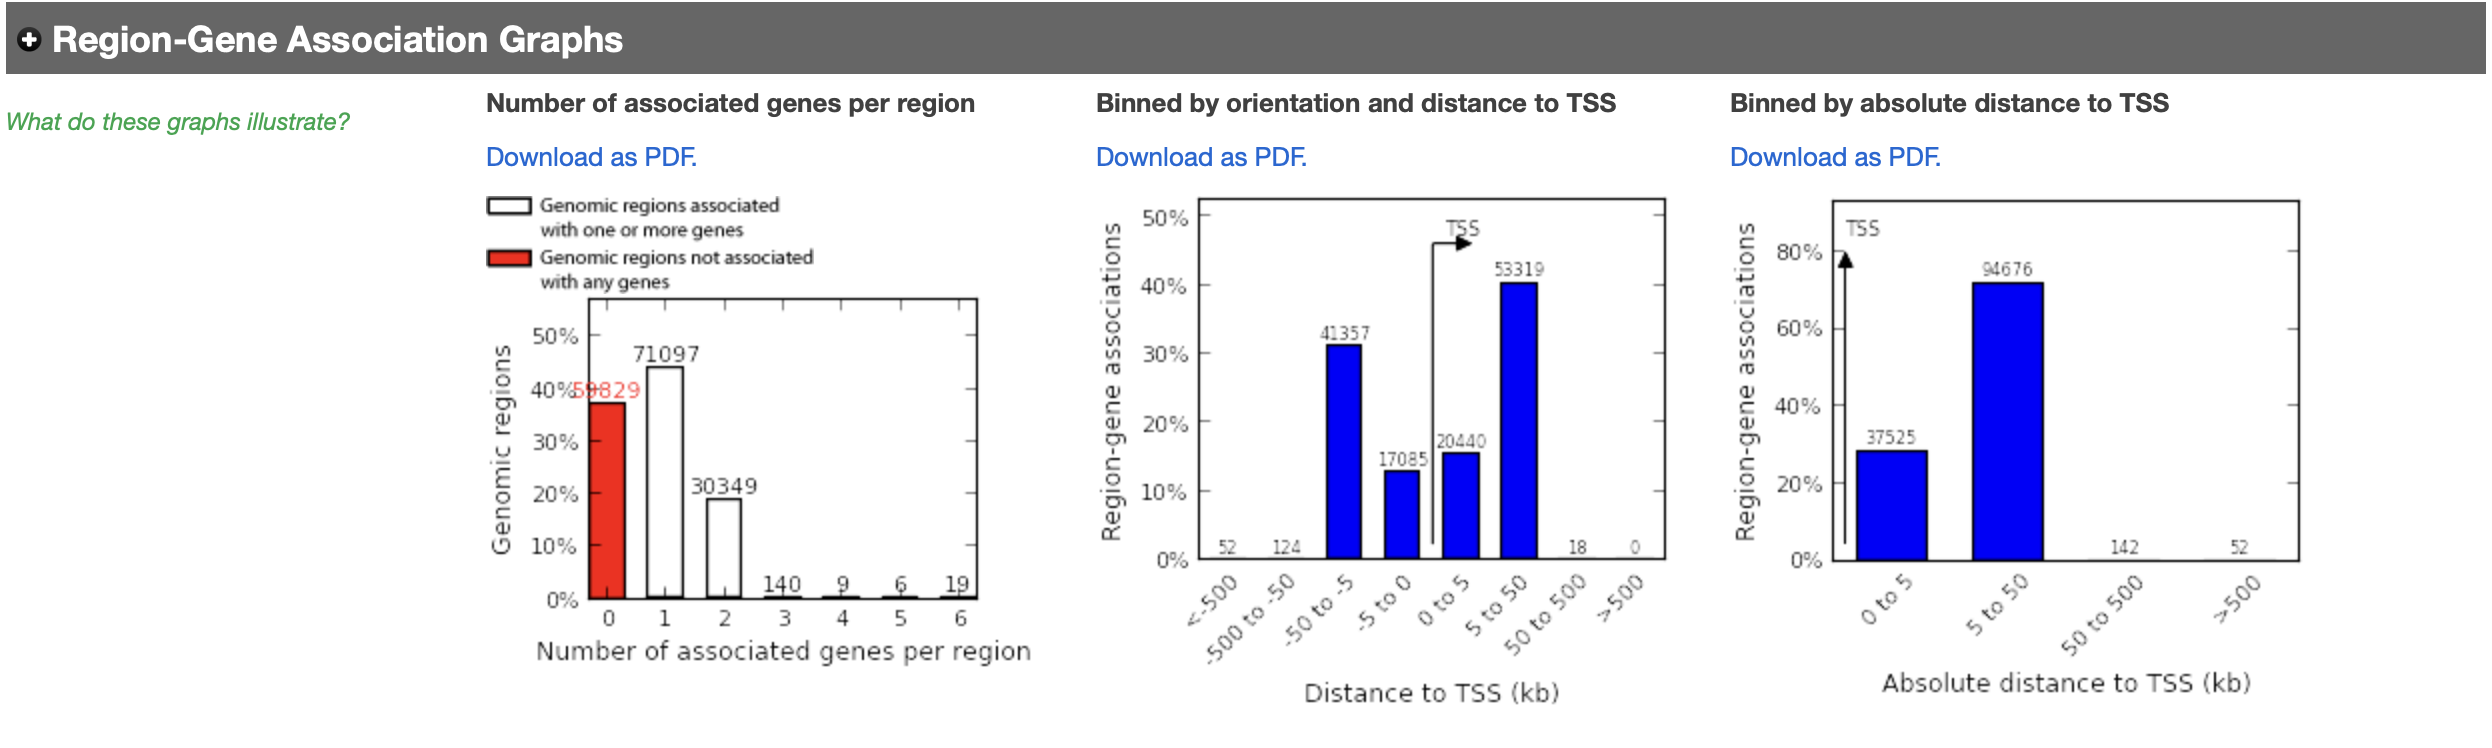

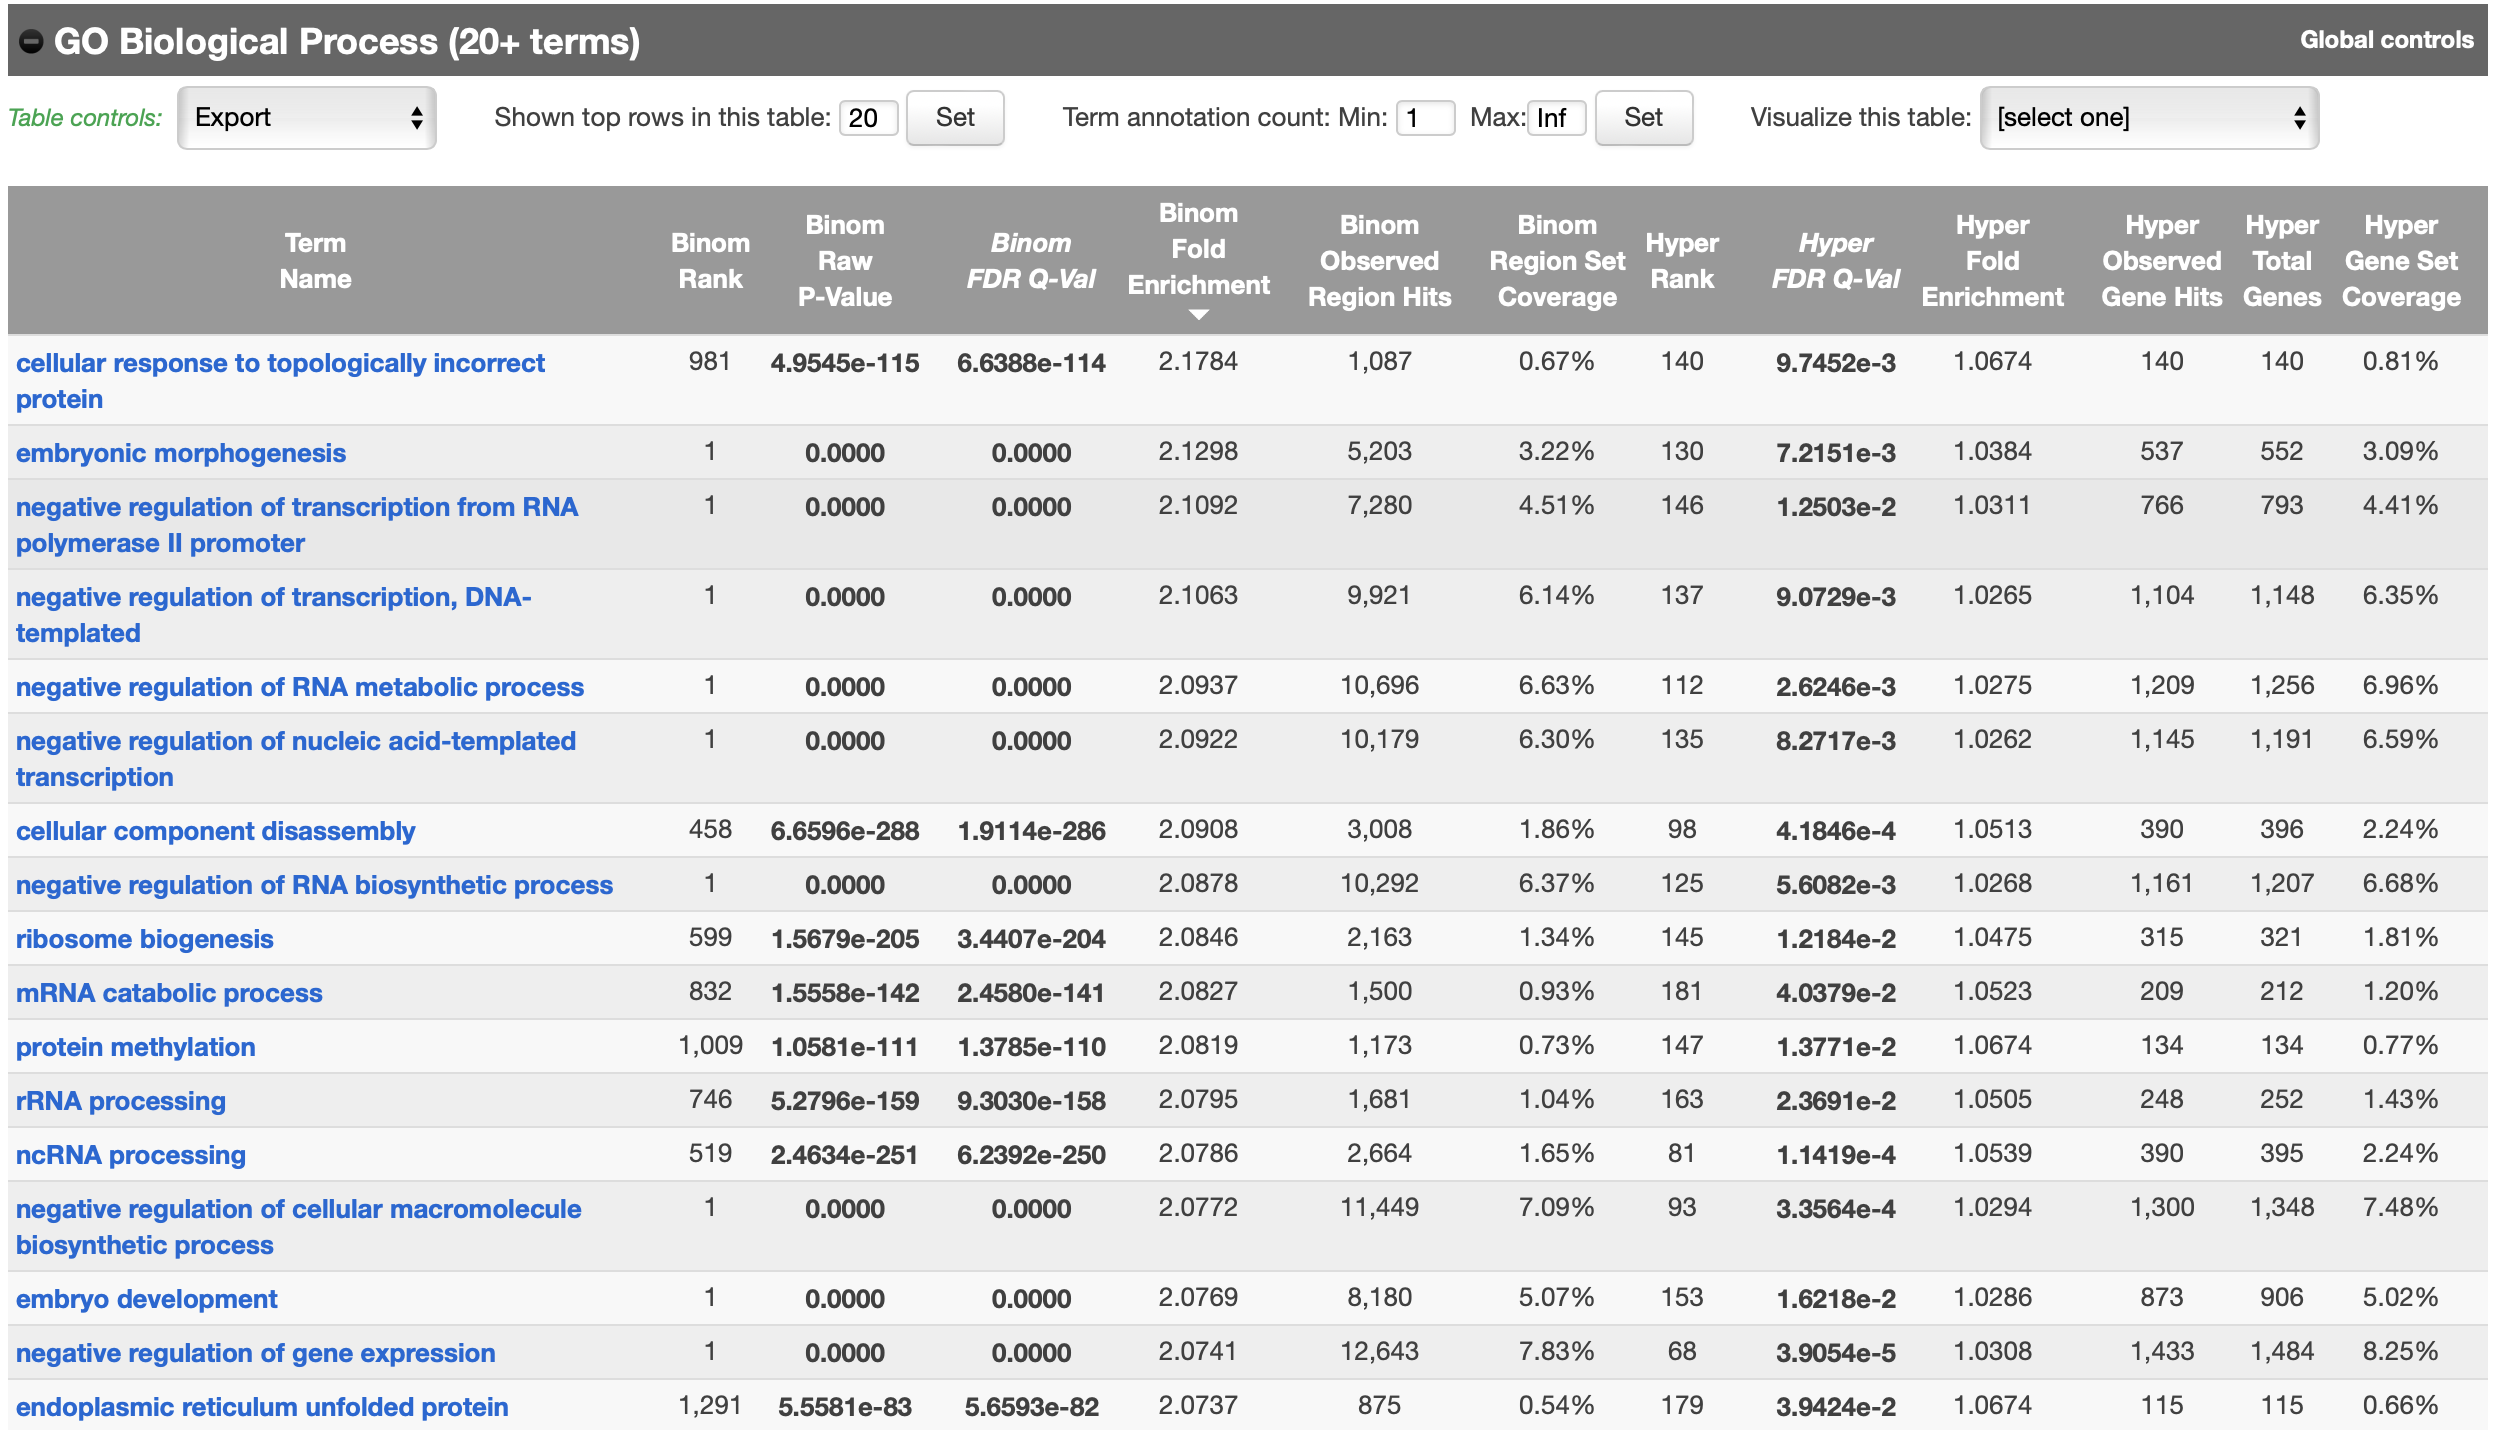

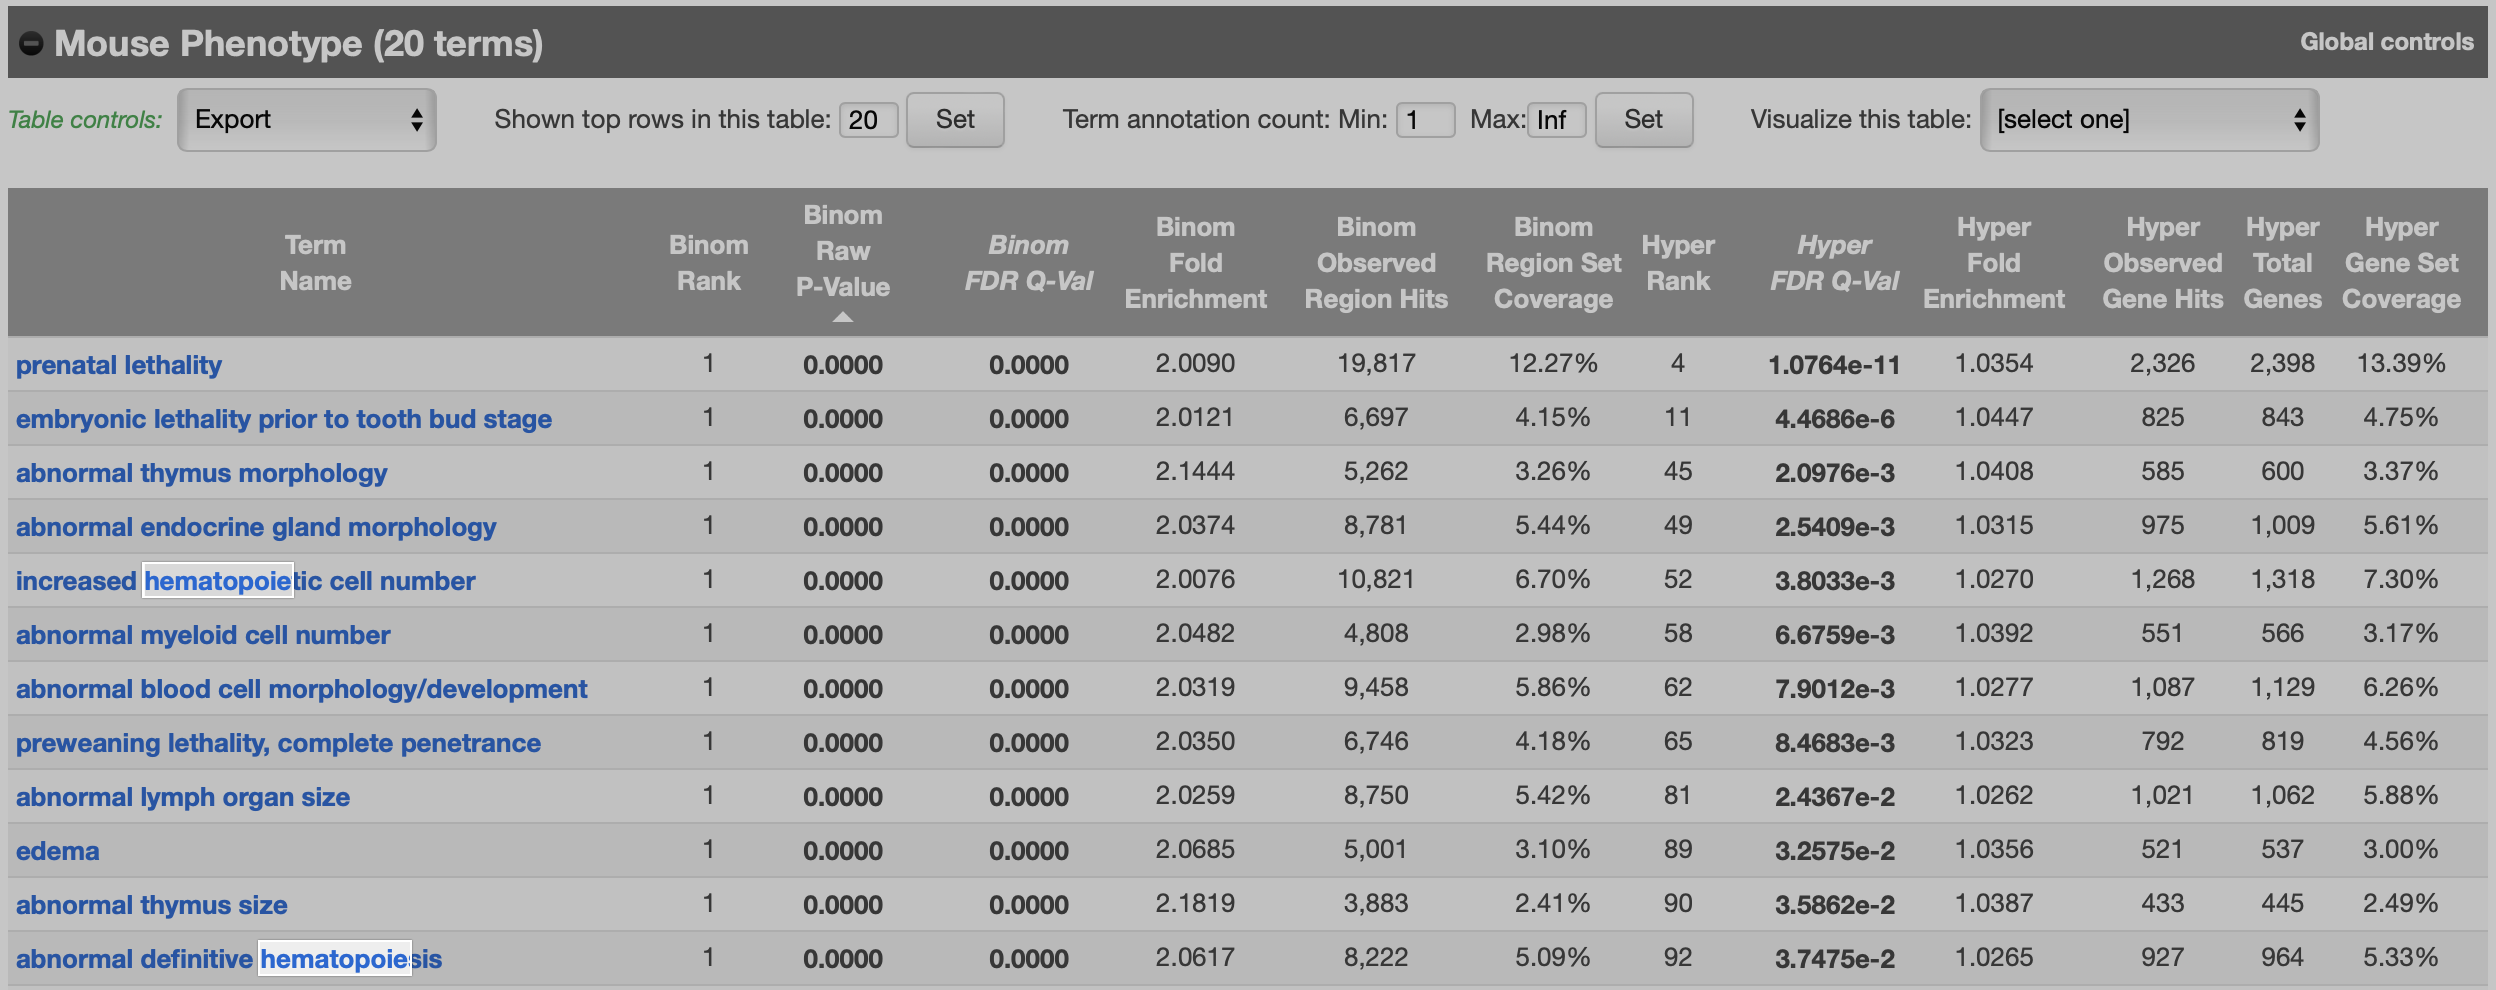

In [4]:
cd /home/luna.kuleuven.be/r0913112/data/jupyternotebooks/Regulatory-Genomics/Task-2-1

head 20231230-public-4.0.4-dX9IJO-hg19-all-gene.txt

# GREAT version 4.0.4	Species assembly: hg19	Association rule: Basal+extension: 5000 bp upstream, 1000 bp downstream, 50000 bp max extension, curated regulatory domains included
A1BG	unnamed (-2905), unnamed (-1104), unnamed (+292), unnamed (+2991), unnamed (+6208), unnamed (+8920), unnamed (+14721), unnamed (+18420), unnamed (+19809)
A1CF	unnamed (+4525), unnamed (+20855)
A2M	unnamed (-8557)
A2ML1	unnamed (-15083)
A3GALT2	unnamed (-47589), unnamed (-47313), unnamed (-46907), unnamed (-46102), unnamed (-43034), unnamed (-40585), unnamed (-33912), unnamed (-29336), unnamed (-28433), unnamed (-10761), unnamed (-4333), unnamed (-76), unnamed (+545), unnamed (+6567), unnamed (+11134), unnamed (+11606), unnamed (+14114), unnamed (+22277), unnamed (+25885), unnamed (+26351), unnamed (+39328), unnamed (+40701), unnamed (+44740)
A4GALT	unnamed (-37155), unnamed (-28262), unnamed (-25226), unnamed (+3424), unnamed (+6400), unnamed (+25305), unnamed (+28821), unnamed (+39844)
AAAS	unnamed (-4193

In [5]:
cat 20231230-public-4.0.4-dX9IJO-hg19-all-gene.txt | cut -f 1 | grep -v '#' | wc -l

17378


In [6]:
cat 20231230-public-4.0.4-dX9IJO-hg19-all-gene.txt | cut -f 1 | grep -v '#' | grep GATA2

GATA2


In [7]:
cat 20231230-public-4.0.4-dX9IJO-hg19-all-gene.txt | cut -f 1 | grep -v '#' > MYB-targets-GREAT.txt

## Comparison of predicted targets with functional associations
Finally, I will use the STRING database to see if more of these genes are "related" to MYB. Here, we can obtain a network of associated genes to MYB, based on genetic interactions, physical interactions, co-expression, and literature.
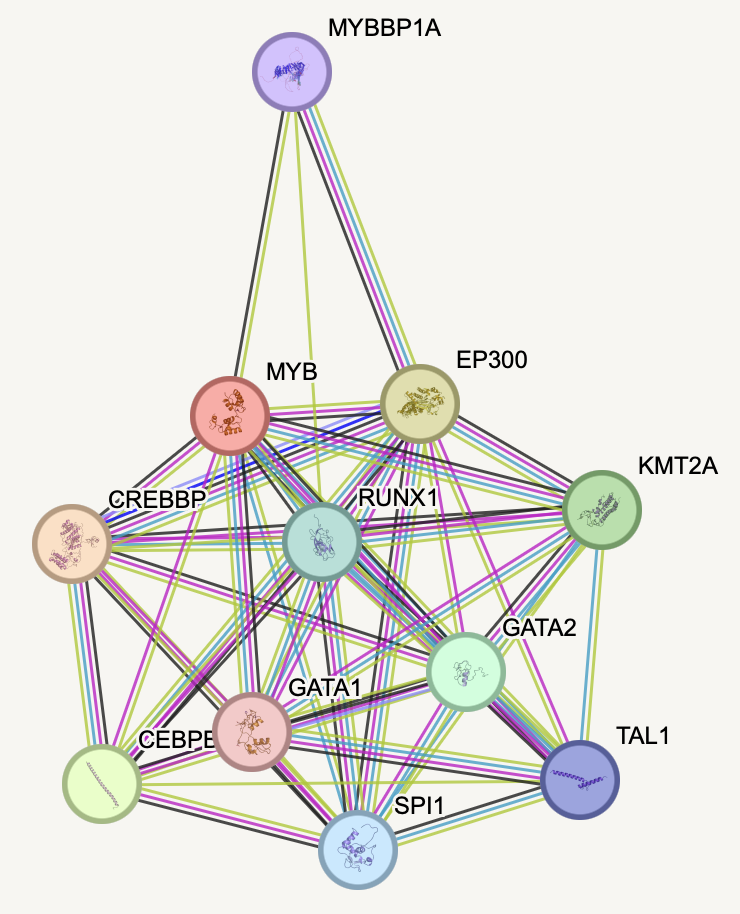
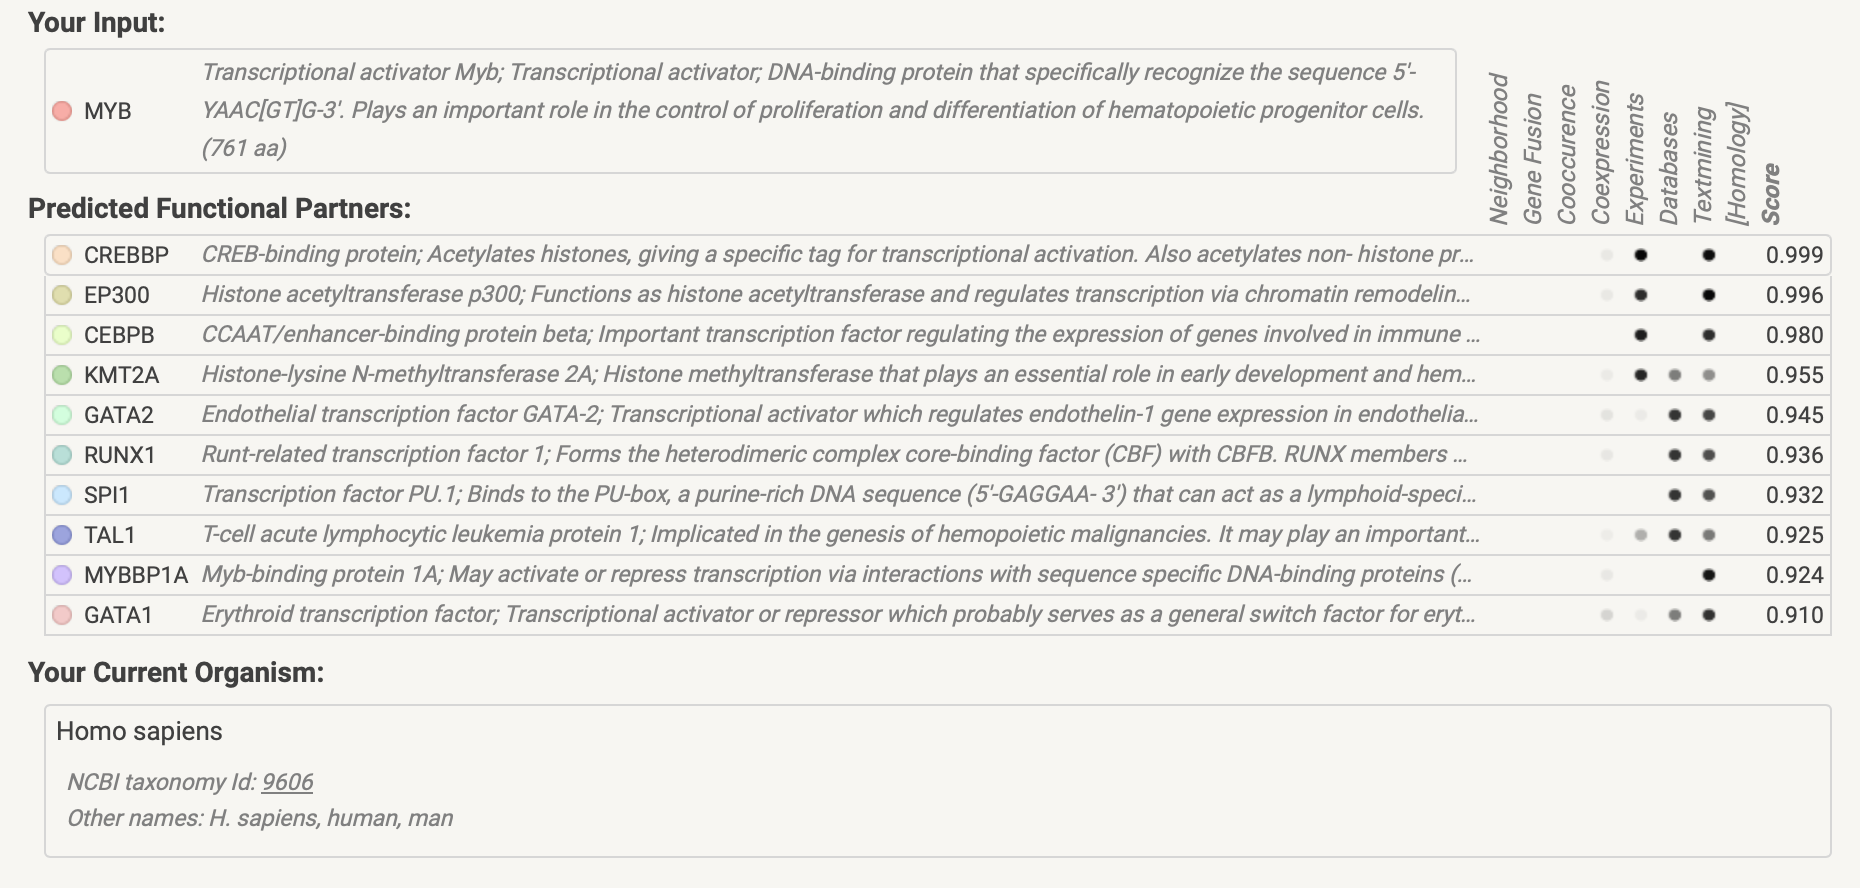

In [8]:
cat string_protein_annotations.tsv | cut -f1 | head

#node
CEBPB
CREBBP
EP300
GATA1
GATA2
KMT2A
MYB
MYBBP1A
RUNX1


In [9]:
cat string_protein_annotations.tsv | cut -f 1 | grep -v '#' > myb-string-top100.txt

In [10]:
list=`cat myb-string-top100.txt`

In [11]:
for i in $list; do grep -w $i MYB-targets-GREAT.txt; done

CEBPB
CREBBP
EP300
GATA1
GATA2
KMT2A
MYB
MYBBP1A
RUNX1
SPI1
TAL1


In [12]:
for i in $list; do grep -w $i MYB-targets-GREAT.txt; done > targets.txt

In [14]:
more targets.txt

CEBPB
CREBBP
EP300
GATA1
GATA2
KMT2A
MYB
MYBBP1A
RUNX1
SPI1
TAL1


This short list of genes:
- has a ChIP-Seq peak nearby (<50kb)
- is associated with the transcription factor MYB 

These are very good candidates to be MYB direct targets. 